<a href="https://colab.research.google.com/github/mirkousuelli/time-series-analysis/blob/main/recursive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

%matplotlib inline

# Recursive Least Square method
In order to best estimate the recent dynamics, less weight should be given to past data; this may be achieved by modifying the cost as follows:

> $J(\theta)=\frac{1}{t}\sum_{1}^{t}\mu^{t-1}\epsilon(i)^2$

where $\mu \in (0, 1]$ : <b> forgetting factor </b> (FF)

## RLS I form with FF
\begin{equation}
\left\{
\begin{aligned}
 \hat{\theta}_t & = \hat{\theta}_{t-1} + K(t)\epsilon(t) \\
 K(t) & = S(t)^{-1} \phi(t) \\
 \epsilon(t) & = y(t) - \phi(t)'\hat{\theta}_{t-1} \\
 S(t) & = \mu S(t-1) + \phi(t)\phi(t)'
\end{aligned} \right.
\end{equation}

where $S(t-1)$ represents the information coming from the past (up to $t-1$), while $\phi(t)\phi(t)'$ represents the fresh information. \\
In the FF variant, such sum is performed by multiplying $S(t-1)$ by coefficient $\mu$; this leads to an attenuation of the importance of past information with respect to the fresh one supplied by $\phi(t)\phi(t)'$.


In [75]:
def rls_with_ff(y, params, samples, ff):
  theta_t = np.array([np.zeros(params)])
  theta_t_1 = np.array([np.zeros(params)]) # theta_t_1 = (1, 2)
  s_t = np.identity(params)
  s_t_1 = np.identity(params) # identity = (2, 2)

  theta_pred = []

  for t in range(params, samples):
    phi_t = np.array([[u_1[t], u_2[t]]]) # phi = (1, 2)
    s_t = ff * s_t_1 + (phi_t.T).dot(phi_t) # s_t = (2, 2) + (2, 1) @ (1, 2) = (2, 2)
    eps_t = y[t] - (phi_t).dot(theta_t_1.T) # eps_t = (1, 1) - (1, 2) @ (2, 1) = (1, 1)
    k_t = inv(s_t).dot(phi_t.T) # k_t = (2, 2) @ (2, 1) = (2, 1)
    theta_t = theta_t_1 + (eps_t).dot(k_t.T) # theta_t = (1, 2) + (1, 1) @ (1, 2)
    theta_t_1 = theta_t
    # storing result
    theta_pred.append(theta_t[0].tolist())

  return theta_pred

## Effect of FF in parameter tracking

### Coefficients

> - $  \theta_1(t)=
\begin{cases}
    1 & t < 400 \\
    sin(\frac{\pi t}{100}+\frac{\pi}{2}) & t \ge 400
\end{cases}
$

> - $\theta_2(t)=1, \forall t$


In [69]:
# theta 1
def theta_1(t):
  return 1 if (t < 400) else np.sin(np.pi * t / 100 + np.pi / 2)

# theta 2
def theta_2(t):
  return 1

### System

A system with two uncorrelated inputs $u_1(t) \sim WN(0,1)$ and $u_2(t) \sim WN(0,1)$ generates a signal $y(t)$ according to the rule: \

> $y(t)=\theta_1(t)u_1(t)+\theta_2(t)u_2(t)+\xi(t)$ \

with $\xi(t) \sim WN(0, 0.01)$


In [70]:
samples = 1000
params = 2

# u_1(t)
mean_1 = 0
std_1 = 1
# u_2(t)
mean_2 = 0
std_2 = 1
# noise
mean = 0
std = np.sqrt(0.01)

# generating noises
y = np.random.normal(mean, std, samples)
u_1 = np.random.normal(mean_1, std_1, samples)
u_2 = np.random.normal(mean_2, std_2, samples)

# generating the system
for t in range(0, samples):
  y[t] += theta_1(t) * u_1[t] + theta_2(t) * u_2[t]

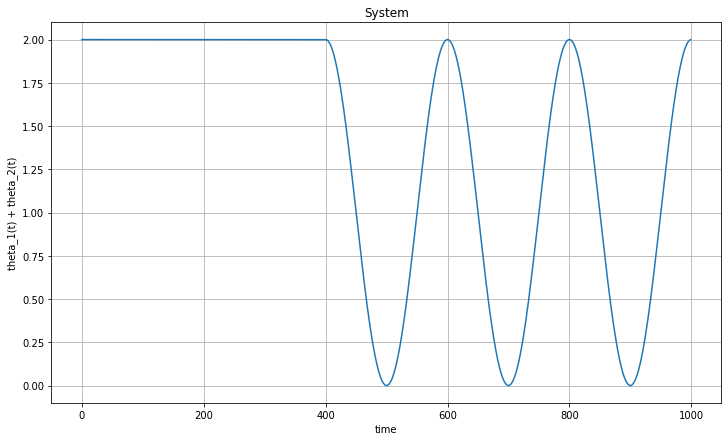

In [71]:
coeff = []

# generating the system
for t in range(0, samples):
  coeff.append(theta_1(t) + theta_2(t))

plt.figure(figsize=[12, 7])
plt.grid()
plt.plot(coeff)
plt.title("System")
plt.xlabel("time")
plt.ylabel("theta_1(t) + theta_2(t)")
plt.show()

### Identification

#### $\mu = 0.6$

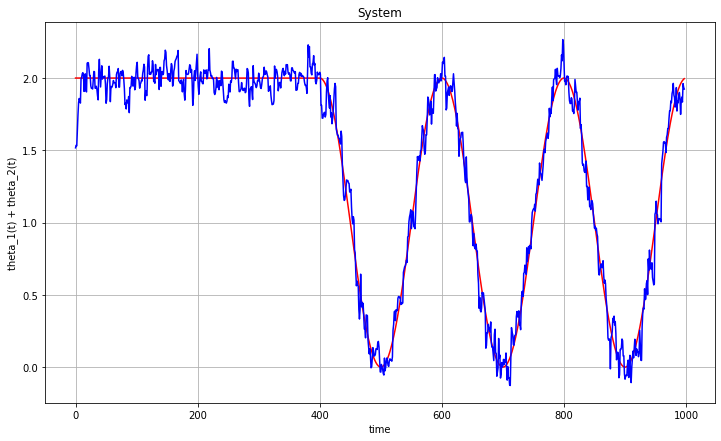

In [76]:
coeff = []
coeff_pred = []

# recursive least square with forgetting factor
theta_pred = rls_with_ff(y, params, samples, 0.6)

# generating the system
for t in range(0, len(theta_pred)):
  coeff.append(theta_1(t) + theta_2(t))
  coeff_pred.append(theta_pred[t][0] + theta_pred[t][1])

# plotting
plt.figure(figsize=[12, 7])
plt.grid()
plt.plot(coeff, color="red")
plt.plot(coeff_pred, color="blue")
plt.title("System")
plt.xlabel("time")
plt.ylabel("theta_1(t) + theta_2(t)")
plt.show()